<div style="padding:10px; 
            color:black;
            margin:10px;
            font-size:150%;
            display:block;
            border-radius:1px;
            border-style: solid;
            border-color:skyblue;
            background-color:#00EFFF;
            overflow:hidden;">
    <center>
        <a id='top'></a>
        <b style="color:black">Table of Contents</b>
    </center>
    <ul>
        <li>
            <a href="#1" style="color:black">1 -  Imports</a>
        </li>
        <li>
            <a href="#2" style="color:black">2 - Data Loading and Analysis</a>
        </li>
         <li>
            <a href="#3" style="color:black">3 - Data Preprocessing</a>
        </li>
            <li>
            <a href="#4" style="color:black">4 - Model Implementation </a>
        </li>
        <li>
            <a href="#5" style="color:black">5 - Evaluation</a>
        </li>
        <li>
            <a href="#6" style="color:black">6 - Thank you</a>
        </li>
    </ul>
</div>


<a id="1"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: #000000;'>Imports</center></h1>

# Imports

In [1]:
import numpy as np
import pandas as pd
import emoji

import pprint
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

<a id="2"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: #000000;'>Data Loading and Analysis</center></h1>

# Data Loading and Analysis

In [2]:
emoji_dictionary = {"0": "\u2764\ufe0f",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

In [3]:
emoji_to_name = {"0": "heart",   
                    "1": "baseball",
                    "2": "smile",
                    "3": "disappointed",
                    "4": "fork_and_knife"}

In [4]:

emoji_to_name = {"0": "heart",   
                    "1": "baseball",
                    "2": "smile",
                    "3": "disappointed",
                    "4": "fork_and_knife"}

In [5]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        words_to_index = {}
        index_to_words = {}
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        for i, w in enumerate(sorted(words), start=1):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/kaggle/input/glove6b50dtxt/glove.6B.50d.txt')

In [6]:
def read_csv(path='/kaggle/input/emojify/'):
    df = pd.read_csv(path, header=None, usecols=[0,1])
    X = df.iloc[:,0].values
    y = df.iloc[:,1].values
    return X, y

In [7]:
X_train, y_train = read_csv(path='/kaggle/input/emojify/train_emoji.csv')
X_test, y_test = read_csv(path='/kaggle/input/emojify/test_emoji.csv')
X_test = np.array([sentence.rstrip() for sentence in X_test])

In [8]:
def read_csv(path='/kaggle/input/emojify/'):
    df = pd.read_csv(path, header=None, usecols=[0,1])
    X = df.iloc[:,0].values
    y = df.iloc[:,1].values
    return X, y
    

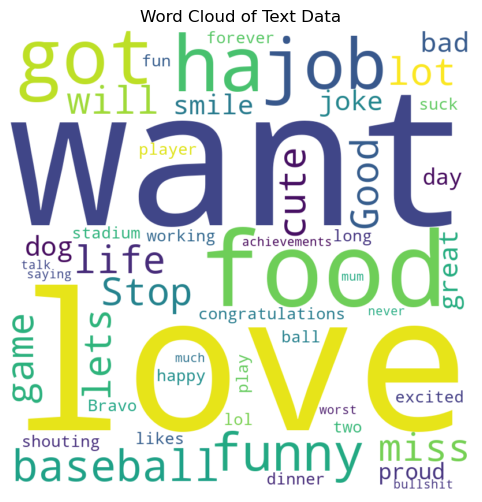

In [9]:
text = ' '.join(X_train)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=50, collocations=False).generate(text)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
ax.set_title('Word Cloud of Text Data')
plt.show()

In [10]:
emoji_counts = dict(zip(*np.unique(y_train, return_counts=True)))
emoji_labels = [emoji_to_name[str(emoji)] for emoji in emoji_counts.keys()]
fig = px.bar(x=emoji_labels, y=list(emoji_counts.values()), color=list(emoji_counts.keys()),
             color_discrete_sequence=px.colors.qualitative.Dark24, title='Distribution of Emojis')
fig.update_xaxes(title='Emoji')
fig.update_yaxes(title='Count')
fig.show()

<a id="3"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: #000000;'>Data Preprocessing</center></h1>

# Data Preprocessing

In [11]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Convert a list of sentences X to a numpy array of word indices using the provided word_to_index mapping.
    Arguments:
    X -- list of sentences
    word_to_index -- dictionary that maps each word in the vocabulary to a unique index
    max_len -- maximum length of a sentence
    Returns:
    X_indices -- numpy array of shape (m, max_len) where m is the number of sentences in X and each row in X_indices represents a sentence in X as a sequence of word indices
    """
    # Get the number of training examples
    m = X.shape[0]

    # Initialize X_indices with zeros
    X_indices = np.zeros((m, max_len))

    # Loop over all the training examples
    
    for i in range(m):
        
        # Split the sentence into words and convert to lowercase
        sentence_words = (X[i].lower()).split()
        for j, w in enumerate(sentence_words):
            # Lookup the index of the word in the vocabulary and store it in X_indices
            X_indices[i, j] = word_to_index[w]   # lookup index of word from vocabulary
            
    return X_indices

In [12]:
max_length  = len(max(X_train, key=len).split())

In [13]:
# Get indices for training and testing data
X_train_indices = sentences_to_indices(X_train, word_to_index, max_length)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_length)

<a id="4"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: #000000;'>Model Implementation</center></h1>

# Model Implementation

In [14]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    # Get the vocabulary size and dimensionality of the GloVe word vectors
    vocab_size = len(word_to_index) + 1  # Adding 1 to fit Keras embedding layer requirement
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]

    # Initialize the embedding matrix with zeros
    emb_matrix = np.zeros((vocab_size, emb_dim))

    # Loop over all words in the vocabulary and lookup their GloVe vector representation
    for word, idx in word_to_index.items():
        if word in word_to_vec_map:
            emb_matrix[idx, :] = word_to_vec_map[word]

    # Define the Keras embedding layer with pre-trained weights
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)

    # Build the embedding layer and set the weights using the embedding matrix
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    # Return the embedding layer
    return embedding_layer

In [15]:
# Define the input layer for the sentence indices
sentence_indices = tf.keras.Input(shape=(max_length,), dtype='int32')

# Load in pre-trained GloVe embeddings using the function defined earlier
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

# Create an embedding layer with pre-trained weights and apply to the sentence indices
embeddings = embedding_layer(sentence_indices)

# Add a Bidirectional LSTM layer with 128 units and return sequences for each time step
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)

# Apply a 50% dropout to the output of the first LSTM layer
X = tf.keras.layers.Dropout(0.5)(X)

# Add a second Bidirectional LSTM layer with 128 units and return only the final output
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(X)

# Apply a 50% dropout to the output of the second LSTM layer
X = tf.keras.layers.Dropout(0.5)(X)

# Add a final output layer with 5 units and softmax activation for multi-class classification
X = tf.keras.layers.Dense(5,activation='softmax')(X)

# Create a Keras model using the input layer and output layer
model = tf.keras.models.Model(inputs=sentence_indices, outputs=X)


In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.fit(X_train_indices, y_train, epochs = 50,verbose=2)

Epoch 1/50
5/5 - 12s - loss: 1.5571 - accuracy: 0.2879 - 12s/epoch - 2s/step
Epoch 2/50
5/5 - 0s - loss: 1.4925 - accuracy: 0.2955 - 44ms/epoch - 9ms/step
Epoch 3/50
5/5 - 0s - loss: 1.3621 - accuracy: 0.4545 - 45ms/epoch - 9ms/step
Epoch 4/50
5/5 - 0s - loss: 1.2649 - accuracy: 0.5530 - 44ms/epoch - 9ms/step
Epoch 5/50
5/5 - 0s - loss: 1.1291 - accuracy: 0.5833 - 44ms/epoch - 9ms/step
Epoch 6/50
5/5 - 0s - loss: 0.9260 - accuracy: 0.6970 - 43ms/epoch - 9ms/step
Epoch 7/50
5/5 - 0s - loss: 0.8065 - accuracy: 0.7273 - 47ms/epoch - 9ms/step
Epoch 8/50
5/5 - 0s - loss: 0.7038 - accuracy: 0.7045 - 44ms/epoch - 9ms/step
Epoch 9/50
5/5 - 0s - loss: 0.6149 - accuracy: 0.7955 - 44ms/epoch - 9ms/step
Epoch 10/50
5/5 - 0s - loss: 0.6235 - accuracy: 0.7879 - 44ms/epoch - 9ms/step
Epoch 11/50
5/5 - 0s - loss: 0.4474 - accuracy: 0.8333 - 45ms/epoch - 9ms/step
Epoch 12/50
5/5 - 0s - loss: 0.3803 - accuracy: 0.8561 - 44ms/epoch - 9ms/step
Epoch 13/50
5/5 - 0s - loss: 0.3645 - accuracy: 0.9015 - 43ms/

<a id="5"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: #000000;'>Evaluation</center></h1>

# Evaluation

In [18]:
model.evaluate(X_test_indices, y_test)

2/2 [==============================] - 1s 10ms/step - loss: 0.4553 - accuracy: 0.8571


[0.4553002417087555, 0.8571428656578064]

In [19]:
def predict(sentence_indices):
    """
    Predicts the emoji for a given input sentence using the trained Keras model.
    
    Arguments:
    sentence_indices -- numpy array of sentence indices, shape (m, max_length)
    
    Returns:
    emojis -- list of predicted emojis
    """
    # Expand the array if it only has one dimension
    if sentence_indices.ndim == 1:
        sentence_indices = np.expand_dims(sentence_indices, axis=0)
        
    # Use the trained Keras model to make predictions
    predictions = model.predict(sentence_indices, verbose=0)
  
    # Find the index of the maximum value in each prediction array
    predictions = np.argmax(predictions,axis=1)
    
    # Map the predicted label to the corresponding emoji using the label_to_emoji() function
    emojis = [label_to_emoji(prediction) for prediction in predictions]

    return emojis

In [20]:
def emojify(sentence_indices, sentence):
    """Emojifies a sentence by appending an emoji to each word based on a prediction model.

    Args:
        sentence_indices (list): A list of integers representing the indices of words in the sentence.
        sentence (str): The input sentence to be emojified.

    Returns:
        list: A list of emojified sentences, where each sentence consists of the original sentence with an
              emoji appended to each word.
    """
    emojified_sentences = [] # create an empty list to hold emojified sentences
    emojis = predict(sentence_indices) # call a prediction model to get emojis for each word in the sentence
    for i in range(len(emojis)): # iterate over the list of emojis
        emojified_sentence = sentence[i] + " " + emojis[i] # concatenate the original word and its corresponding emoji
        emojified_sentences.append(emojified_sentence) # add the emojified word to the list of emojified sentences
    return emojified_sentences # return the list of emojified sentences


In [21]:
def label_to_emoji(label: str) -> str:
    """
    Returns an emoji corresponding to the given label from the emoji dictionary.

    Parameters:
    label (str): A string representing a label in the emoji dictionary.

    Returns:
    str: An emoji corresponding to the given label.

    Raises:
    KeyError: If the given label is not found in the emoji dictionary.
    """
    # Convert the label to a string and retrieve the corresponding emoji from the dictionary
    emoji_code = emoji_dictionary[str(label)]

    # Use the emojize() function from the emoji module to convert the emoji code to an actual emoji
    emoji_alias = emoji.emojize(emoji_code, language='alias')

    return emoji_alias

In [22]:
emojified_sentences = emojify(X_test_indices[0:10], X_test[0:10])

In [23]:
pprint.pprint(emojified_sentences)

['I want to eat 🍴',
 'he did not answer 😞',
 'he got a very nice raise 😄',
 'she got me a nice present 😄',
 'ha ha ha it was so funny 😄',
 'he is a good friend 😄',
 'I am upset 😞',
 'We had such a lovely dinner tonight 😄',
 'where is the food 🍴',
 'Stop making this joke ha ha ha 😄']


<a id="6"></a>
<h1 style='background:#00EFFF;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: #3E3D53;'>Thank you</center></h1>

# Thank you

**Thank you for going through this notebook**

**If you have any suggestions please let me know**